In [ ]:
!pip install tensorflow tqdm

## Imports

In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

## Unzip dataset

In [ ]:
!unzip -q "/content/drive/MyDrive/project/combined_dataset.zip" -d "/content/plant_dataset"

unzip:  cannot find or open /content/drive/MyDrive/project/combined_dataset.zip, /content/drive/MyDrive/project/combined_dataset.zip.zip or /content/drive/MyDrive/project/combined_dataset.zip.ZIP.


In [ ]:
!pip install gdown

In [ ]:
# Download the file from Google Drive using the file ID
file_id = '1HL56kxu9y0oaJhfyvkvrOYaszDGQKv_G'
file_name = 'combined_dataset.zip'
!gdown --id {file_id} -O {file_name}

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1HL56kxu9y0oaJhfyvkvrOYaszDGQKv_G
From (redirected): https://drive.google.com/uc?id=1HL56kxu9y0oaJhfyvkvrOYaszDGQKv_G&confirm=t&uuid=8635bf51-d356-4ada-af2a-62687d182761
To: /content/combined_dataset.zip
100% 3.22G/3.22G [00:22<00:00, 141MB/s]


In [ ]:
!unzip -q "{file_name}" -d "/content/plant_dataset"

## parameters

In [ ]:
# Parameters
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
SEED = 42

data_dir = "/content/plant_dataset/combined_dataset"

## Load Dataset

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Detected {num_classes} species:", class_names)


Found 817 files belonging to 85 classes.
Using 654 files for training.
Found 817 files belonging to 85 classes.
Using 163 files for validation.
Detected 85 species: ['Agave_Dasylirioides', 'Agave_Parryi', 'Agave_Striata', 'Ajania_Pacifica', 'Albiflora_Spiraea_Japonica', 'Allium_schoenoprasum_(Chives)', 'Aloe_Bukobana', 'Aloe_Debrana', 'Aloe_Ellenbeckii', 'Aloe_Humilis', 'Alyssum_maritimum', 'Amethyst_Cowichan', 'Apple_Mint_(Mentha_Suaveolens)', 'Arctotis_Midnight_Red', 'Artemisia_afra', 'Ayesha_(Hydrangea_Macrophylla)', 'Baby_Faurax_(Rosa)', 'Bergenia_Ciliata', 'Blue_Chalksticks_(Senecio_Mandraliscae)', 'Brunsvigia_Josephiniae', 'Careus_Monstrosus', 'Chimonanthus_Zhejiangensis', 'Chinese_Fringe', 'Chives_(Allium_Schoenoprasum)', 'Cho-Cho-San_(Camellia_Japonica)', 'Choisya_(White_Dazzler)', 'Coix_Lacrima_jobi', 'Constant_Cheer_(Erysimum)', 'Crispatum_(Farfugium_Japonicum)', 'Daphne_Odora_f_Alba', 'Elegiac_Tectorum_Restiad', 'Erica_Cerinthoides_Red', 'Eryngium_Agavifolium', 'Euphorbia_Ma

## Data augementation

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2),
])

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Build EfficientNet Model

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0

base_model = EfficientNetV2B0(include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # freeze base first

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 85)             │       108,885 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,028,197 (23.00 MB)

 Trainable params: 108,885 (425.33 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

## Callbacks

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("efficientnet_plants.keras", save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.2)
]

## Train the Model

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.1485 - loss: 4.4642 - val_accuracy: 0.4663 - val_loss: 2.1700 - learning_rate: 0.0100
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.5953 - loss: 1.5190 - val_accuracy: 0.5951 - val_loss: 1.5236 - learning_rate: 0.0100
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.7289 - loss: 0.8525 - val_accuracy: 0.6810 - val_loss: 1.1614 - learning_rate: 0.0100
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.8640 - loss: 0.5362 - val_accuracy: 0.6810 - val_loss: 1.2216 - learning_rate: 0.0100
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.8973 - loss: 0.3981 - val_accuracy: 0.6442 - val_loss: 1.2074 - learning_rate: 0.0100
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9092 - loss: 0.3210 - val_accuracy: 0.7178 - val_loss: 1.0752 - learning_rate: 0.0100
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9470 - loss: 0.2488 - val_

In [ ]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.2%}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7678 - loss: 1.0031
Validation Accuracy: 77.91%


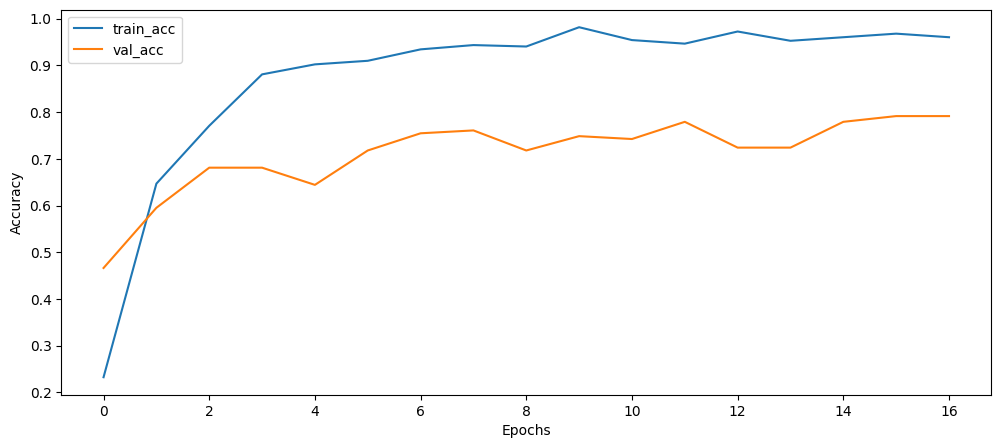

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'] , label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Fine-Tuning

In [ ]:
base_model.trainable = True
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 55s 526ms/step - accuracy: 0.6383 - loss: 1.5873 - val_accuracy: 0.6871 - val_loss: 1.1409 - learning_rate: 0.0010
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 384ms/step - accuracy: 0.9578 - loss: 0.2595 - val_accuracy: 0.7730 - val_loss: 0.8175 - learning_rate: 0.0010
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 380ms/step - accuracy: 0.9741 - loss: 0.1079 - val_accuracy: 0.8221 - val_loss: 0.6710 - learning_rate: 0.0010
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 384ms/step - accuracy: 0.9951 - loss: 0.0481 - val_accuracy: 0.7853 - val_loss: 0.6419 - learning_rate: 0.0010
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 400ms/step - accuracy: 0.9940 - loss: 0.0331 - val_accuracy: 0.8037 - val_loss: 0.6354 - learning_rate: 0.0010
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 319ms/step - accuracy: 0.9952 - loss: 0.0271 - val_accuracy: 0.7791 - val_loss: 0.7969 - learning_rate: 0.0010
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step - accuracy: 0.9938 - loss: 0.0341 -

## Evaluate

In [ ]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.2%}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8778 - loss: 0.4579
Validation Accuracy: 86.50%


## Visualize Training Curves

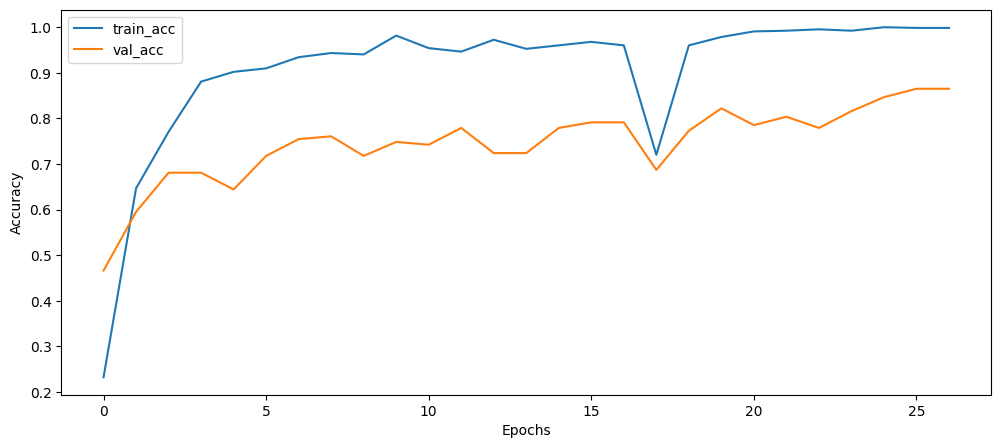

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Visualize Training Curves

By plotting the training and validation accuracy over epochs, we can observe if the model is overfitting. If the training accuracy continues to increase while the validation accuracy plateaus or decreases, it indicates overfitting. Conversely, if both curves increase together, the model is generalizing well.

In [ ]:
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.2%}")
print(f"Validation Accuracy: {val_acc:.2%}")

Final Training Accuracy: 96.02%
Validation Accuracy: 86.50%


In [ ]:
# Save model and class names
model.save("plant_species_model.keras")
with open("class_names.txt", "w") as f:
    for name in class_names:
        f.write(name + "\n")

print("Model and class names saved successfully!")